# **Taiwanese and Indonesian Presidential Inauguration Speech: What Does the Future Hold?**

## **Traditional Chinese- Model V2**



## **Introduction**

This project analyzes presidential inauguration speeches from Taiwan and Indonesia. Both countries are Asian democracies, but they differ in political systems, culture, and historical background. By comparing their inauguration speeches, we aim to understand whether they share similar political themes or express different visions for the future.

We use a topic modeling approach based on multilingual BERT, which allows texts in different languages to be analyzed within the same semantic space. This makes cross-country comparison of political discourse possible.

## **Purpose of the project**

- To apply topic modeling separately to Taiwanese and Indonesian inauguration speeches in order to identify the main themes in each country
- To select the better-performing model and then combine both corpora to compare topics using cosine similarity, measuring how similar or different the themes are across countries.

To ensure model quality, we test two configurations, v2 and H384. For each model, we conduct parameter tuning and diagnostic evaluation to examine trade-offs between coherence, topic separation, and topic diversity. Based on these results, we select the more suitable model for cross-country analysis.

In this notebook, we present the full workflow, including text preprocessing, topic modeling with the v2 model, parameter tuning, and diagnostic analysis. This workflow forms the basis for the final comparative study.


In [1]:
!jupyter nbconvert \
  --ClearMetadataPreprocessor.enabled=True \
  --inplace \
  Topic_Modeling_Taiwanese_President_Speech_V2.ipynb



[NbConvertApp] WARNING | pattern 'Topic_Modeling_Taiwanese_President_Speech_V2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterA

# **1. Import Libraries**

In [ ]:
!pip install requests nltk spacy bertopic gensim
!apt-get -y install fonts-noto-cjk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [ ]:
# for scrapper
import requests
from bs4 import BeautifulSoup
import os
import re

# others
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import math
import statistics
import pickle

# topic modelling

from nltk.tokenize import RegexpTokenizer
from itertools import combinations
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
import requests
from bs4 import BeautifulSoup
from transformers import AutoTokenizer

# **2. Import Data**

- Dataset: Preseident inauguration speech(2024)


Key Details

- Source: Office of the President Republic of China(Taiwan)

- URL: https://www.president.gov.tw/Page/700

- Mothod of collection : Scrapping

- Number of tokens: 5297(each token is a single character in tradiyion chinese)

- Feature types: Texts

- Subject area: Political Science

In [ ]:
#load files

url = "https://www.president.gov.tw/NEWS/28428"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
response.encoding = "utf-8"

soup = BeautifulSoup(response.text, "html.parser")

speech_div = soup.find("div", class_="article1")

if speech_div is None:
    raise ValueError(" missing article1")

df = speech_div.get_text(separator="\n", strip=True)

with open("full_speech_chinese.txt", "w", encoding="utf-8") as f:
    f.write(df)
unwanted = "中華民國第16任總統賴清德伉儷及副總統蕭美琴今（20）日上午參加在總統府府前廣場舉行的就職慶祝大會，總統並以「打造民主和平繁榮的新臺灣」為題，發表就職演說，演說全文為："

df = df.replace(unwanted, "").strip()

df

'蕭美琴副總統、各位友邦的元首與貴賓、各國駐臺使節代表、現場所有的嘉賓，電視機前、還有線上收看直播的好朋友，全體國人同胞，大家好：\n我年輕的時候，立志行醫救人。我從政的時候，立志改變臺灣。現在，站在這裡，我立志壯大國家！\n我以無比堅定的心情，接受人民的託付，就職中華民國第十六任總統，我將依據中華民國憲政體制，肩負起帶領國家勇往前進的重責大任。\n回想1949年的今天，臺灣實施戒嚴，全面進入專制的黑暗年代。\n1996年的今天，臺灣第一位民選總統宣誓就職，向國際社會傳達，中華民國臺灣是一個主權獨立的國家、主權在民。\n2024年的今天，臺灣在完成三次政黨輪替之後，第一次同一政黨連續執政，正式展開第三任期！臺灣也揚帆進入一個充滿挑戰，又孕育無限希望的新時代。\n這段歷程，是這塊土地上的人們，前仆後繼、犧牲奉獻所帶來的結果。雖然艱辛，但我們做到了！\n此時此刻，我們不只見證新政府的開始，也是再一次迎接得來不易的民主勝利！\n許多人將我和蕭美琴副總統的當選，解讀為「打破八年政黨輪替魔咒」。事實上，民主就是人民作主，每一次的選舉，虛幻的魔咒並不存在，只有人民對執政黨最嚴格的檢驗、對國家未來最真實的選擇。\n我要感謝，過去八年來，蔡英文前總統、陳建仁前副總統和行政團隊的努力，為臺灣的發展，打下堅實的基礎。也請大家一起給他們一個最熱烈的掌聲！\n我也要感謝國人同胞大家的支持，不受外來勢力的影響，堅定守護民主，向前走；不回頭，為臺灣翻開歷史的新頁！\n在未來任期的每一天，我將「行公義，好憐憫，存謙卑的心」，「視民如親」，不愧於每一分信賴與託付。新政府也將兢兢業業，拿出最好的表現，來接受全民的檢驗。我們的施政更要不斷革新，開創臺灣政治的新風貌。\n一、行政立法協調合作，共同推動國政\n今年二月上任的新國會，是臺灣時隔十六年後，再次出現「三黨不過半」的立法院。面對這個政治新局，有些人抱持期待，也有些人感到憂心。\n我要告訴大家，這是全民選擇的新模式，當我們以新思維看待「三黨不過半」，這代表著，朝野政黨都能分享各自的理念，也將共同承擔國家的種種挑戰。\n然而，全民對於政黨的理性問政，也有很大的期待。政黨在競爭之外，也應該有合作的信念，國家才能踏出穩健的步伐。\n立法院的議事運作，應該遵守程序正義，多數尊重少數，少數服從多數，才能避免衝突，維持社會的安定和諧。\n在民主社會，人民的利益

In [ ]:

tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-chinese",
    use_fast=True
)
text = df

token_count = len(tokenizer.tokenize(text))

print("Token count =", token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (5297 > 512). Running this sequence through the model will result in indexing errors


Token count = 5297


# **3. Text Cleaning**

- Removed URLs and HTML tags from the text.
- Normalized whitespace by collapsing multiple spaces and trimming leading.
- Applied cleaning function to all text entries


In [ ]:
df = pd.DataFrame({
    "text": [df]})

texts = df["text"].tolist()

def clean_text(text):
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["cleaned"] = df["text"].apply(clean_text)
print(df.head(5))

df["cleaned"] = df["cleaned"].astype(str)
df = df[df["cleaned"].str.strip() != ""]
df = df[df["cleaned"].str.lower() != "nan"]

                                                text  \
0  蕭美琴副總統、各位友邦的元首與貴賓、各國駐臺使節代表、現場所有的嘉賓，電視機前、還有線上收看...   

                                             cleaned  
0  蕭美琴副總統、各位友邦的元首與貴賓、各國駐臺使節代表、現場所有的嘉賓，電視機前、還有線上收看...  


In [ ]:
print("df type:", type(df))
print("texts type:", type(texts))
print("first element type:", type(texts[0]))
print("sample text preview:", texts[0][:50])

df type: <class 'pandas.core.frame.DataFrame'>
texts type: <class 'list'>
first element type: <class 'str'>
sample text preview: 蕭美琴副總統、各位友邦的元首與貴賓、各國駐臺使節代表、現場所有的嘉賓，電視機前、還有線上收看直播的好


# **4. Splitting into Documents**

### What was done

- Trimmed leading and trailing whitespace for each paragraph.
- Filtered out very short paragraphs.
- Computed token counts check wheter it exceed the limit size for bert model.

### Why this step is needed

For Traditional Chinese text, tokenization behavior differs significantly from Latin alphabet languages, making it necessary to control input length and chunking structure before downstream processing. Splitting long text into paragraph-level documents helps ensure that each unit remains within practical token limits while preserving coherent semantic boundaries.


In [ ]:
def split_paragraphs(text, min_len=20):

    paras = [p.strip() for p in text.split("\n") if len(p.strip()) >= min_len]
    return paras

documents = []
for t in texts:
    documents.extend(split_paragraphs(t))
print("Number of documents (paragraphs):", len(documents))
for i, d in enumerate(documents[:5]):
    print(f"\n--- Paragraph {i} ---")
    print(d[:200])

Number of documents (paragraphs): 79

--- Paragraph 0 ---
蕭美琴副總統、各位友邦的元首與貴賓、各國駐臺使節代表、現場所有的嘉賓，電視機前、還有線上收看直播的好朋友，全體國人同胞，大家好：

--- Paragraph 1 ---
我年輕的時候，立志行醫救人。我從政的時候，立志改變臺灣。現在，站在這裡，我立志壯大國家！

--- Paragraph 2 ---
我以無比堅定的心情，接受人民的託付，就職中華民國第十六任總統，我將依據中華民國憲政體制，肩負起帶領國家勇往前進的重責大任。

--- Paragraph 3 ---
回想1949年的今天，臺灣實施戒嚴，全面進入專制的黑暗年代。

--- Paragraph 4 ---
1996年的今天，臺灣第一位民選總統宣誓就職，向國際社會傳達，中華民國臺灣是一個主權獨立的國家、主權在民。


In [ ]:

doc_token_counts = [
    len(tokenizer.encode(doc, add_special_tokens=True))
    for doc in documents
]

df_token_stats = pd.DataFrame({
    "document": documents,
    "token_count": doc_token_counts
})
df_token_stats.head(5)

,document,token_count
0,蕭美琴副總統、各位友邦的元首與貴賓、各國駐臺使節代表、現場所有的嘉賓，電視機前、還有線上收看...,66
1,我年輕的時候，立志行醫救人。我從政的時候，立志改變臺灣。現在，站在這裡，我立志壯大國家！,46
2,我以無比堅定的心情，接受人民的託付，就職中華民國第十六任總統，我將依據中華民國憲政體制，肩負...,63
3,回想1949年的今天，臺灣實施戒嚴，全面進入專制的黑暗年代。,29
4,1996年的今天，臺灣第一位民選總統宣誓就職，向國際社會傳達，中華民國臺灣是一個主權獨立的國...,52


# **5.Model Training - MiniLM-L12-v2**


In [ ]:
from sentence_transformers import SentenceTransformer

MODEL_NAME_V2 = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model_v2 = SentenceTransformer(MODEL_NAME_V2)

def encode_v2(texts):
    return model_v2.encode(texts, convert_to_numpy=True)


In [ ]:
import jieba

def jieba_tokenizer(text):
    return list(jieba.cut(text))

In [ ]:
umap_model_v2 = UMAP(
    n_neighbors=8,
    n_components=3,
    min_dist=0.0,
    metric="euclidean",
    random_state=42
)

hdbscan_model_v2 = HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric="euclidean",
    cluster_selection_method="leaf",
    prediction_data=True
)
def jieba_tokenizer(text):
    return list(jieba.cut(text))


stop_words_v2 = [
    "我們","大家","各位","以及","因此",
    "這些","這個","進行","推動","持續",
    "將","也","更"
]

tf_vectorizer_v2 = CountVectorizer(
    tokenizer=jieba_tokenizer,
    stop_words=stop_words_v2,
    ngram_range=(1, 4),
    min_df=1,
    max_df=0.5,
    max_features=5000
)

rep_model_v2 = KeyBERTInspired()
mmr_v2 = MaximalMarginalRelevance(diversity=0.3)

representation_model_v2 = {
    "KeyBERT": rep_model_v2,
    "MMR": mmr_v2
}
topic_model_v2 = BERTopic(
    embedding_model=encode_v2,
    umap_model=umap_model_v2,
    hdbscan_model=hdbscan_model_v2,
    vectorizer_model=tf_vectorizer_v2,
    representation_model=None,   # 🔥 關掉
    calculate_probabilities=True,
    verbose=True
)
topics_v2, probs_v2 = topic_model_v2.fit_transform(documents)

topic_info_v2 = topic_model_v2.get_topic_info()


2026-01-22 09:28:06,735 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2026-01-22 09:28:21,890 - BERTopic - Embedding - Completed ✓
2026-01-22 09:28:21,891 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-22 09:28:22,312 - BERTopic - Dimensionality - Completed ✓
2026-01-22 09:28:22,315 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-22 09:28:22,383 - BERTopic - Cluster - Completed ✓
2026-01-22 09:28:22,397 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-22 09:28:22,807 - BERTopic - Representation - Completed ✓


### Jieba Tokenization and Stop Words

Chinese text does not contain clear word boundaries, so tokenization must be handled explicitly before vectorization. Jieba is used as a dictionary-based Chinese tokenizer to segment raw text into meaningful lexical units. This step allows downstream components such as `CountVectorizer` to operate on word-level or phrase-level features instead of individual characters.

A custom stop word list is applied to remove pronouns, demonstratives, and connective terms.


In [ ]:
topic_info_v2 = topic_model_v2.get_topic_info()
topic_info_v2

,Topic,Count,Name,Representation,Representative_Docs
0,-1,10,-1_為_和平_中華民國_有,"[為, 和平, 中華民國, 有, 民主, 都, 的 發展, 國家, 世界, ！ ]",[臺灣位居「第一島鏈」的戰略位置，牽動著世界地緣政治的發展。早在1921年，蔣渭水先生就指出...
1,0,5,0_世界_是_的 中心_鏈 」,"[世界, 是, 的 中心, 鏈 」, ai, 鏈 」 的, 世界 ，, 中心, ！ , 半導體]","[臺灣需要世界，世界也需要臺灣！臺灣不只是打開世界的大門，臺灣已經走到世界舞台的中心！, 我..."
2,1,5,1_運動_加入_健康_， 進,"[運動, 加入, 健康, ， 進, 進, 讓, ， 要, 讓 臺, 我要, 政府]",[我們立定目標，要讓臺灣成為無人機民主供應鏈的亞洲中心，也要發展下一個世代通訊的中低軌道衛星...
3,2,4,2_會 有_， 會 有_， 會_會,"[會 有, ， 會 有, ， 會, 會, 有, 安全, 社會, ！ 未來, 多數, 安全 、]",[我對未來中央和地方的互相合作、行政和立法的協調運作，寄予厚望，也希望跟所有國人攜手努力，一...
4,3,4,3_對_」_「_人民,"[對, 」, 「, 人民, ， 拿出, 檢驗, 的 選擇, 的 檢驗, 拿出, 事實]",[在未來任期的每一天，我將「行公義，好憐憫，存謙卑的心」，「視民如親」，不愧於每一分信賴與託...
5,4,4,4_人工智慧_轉型_轉型 ，_智慧,"[人工智慧, 轉型, 轉型 ，, 智慧, 投資, 地, 淨零, 淨零 轉型, 化, 人工智慧 的]",[我們也必須發展創新驅動的經濟模式，透過數位轉型，以及淨零轉型的雙軸力量，來協助中小企業升級...
6,5,3,5_感謝_我 要 感謝_要 感謝_國人,"[感謝, 我 要 感謝, 要 感謝, 國人, 再次, 我 要, 面對, 國人 同胞, 同胞,...",[親愛的國人同胞，國家的未來發展，需要每一分力量。面對全球化、全面性競爭的時代，沒有一個國家...
7,6,3,6_更好_我會_， 我會_億元 ， 來,"[更好, 我會, ， 我會, 億元 ， 來, 中央政府 已經 規劃, 中央政府 已經 規劃 ...","[大家期待治安更好，我會積極打擊黑金、槍、毒和詐騙。, 大家希望收入更高，我會推動產業升級，..."
8,7,3,7_國人 同胞 ，_的 未來_同胞 ，_國人,"[國人 同胞 ，, 的 未來, 同胞 ，, 國人, 中國, 國人 同胞, 同胞, 未來, 未...","[各位國人同胞，民主、和平、繁榮是臺灣的國家路線，也是臺灣與世界的連結。, 各位國人同胞，當..."
9,8,3,8_我_立志_可以_的 時候,"[我, 立志, 可以, 的 時候, 的 時候 ， 立志, 時候 ， 立志, ， 立志, 時候...",[我了解國人對生活的煩惱和期待，凡是各位關心的議題、社會需要的改革，政府都會積極以對，全力以...


### **Short Conclusion**

The modeling results indicate that the corpus is primarily centered on political discourse, with a strong focus on national identity, governance, democracy, social stability, and future development. In addition, there are recurring themes related to reform, innovation, economic transformation, and technological development, suggesting an emphasis on forward-looking narratives.  Overall, the topics reflect a mixture of ideological statements, policy-oriented messaging, and societal aspirations, structured around formal public communication.






# **6. Topic Result Diagnostic**
### **Topic Coherence**

In [ ]:
top_words_dict_v2 = {}

for topic_id, words_scores in topic_model_v2.get_topics().items():
    if topic_id == -1:
        continue
    top_words_dict_v2[topic_id] = [w for w, _ in words_scores]

In [ ]:

vectorizer_v2 = topic_model_v2.vectorizer_model

texts_cleaned_v2 = [
    vectorizer_v2.build_tokenizer()(doc)
    for doc in documents
]

from gensim.corpora import Dictionary

dictionary_v2 = Dictionary(texts_cleaned_v2)
dictionary_v2.filter_extremes(no_below=1, no_above=0.9)

dictionary_vocab_v2 = set(dictionary_v2.token2id.keys())
topics_for_gensim_v2 = []
topic_ids_for_gensim_v2 = []

for topic_id, words_scores in topic_model_v2.get_topics().items():
    if topic_id == -1:
        continue

    words_v2 = [w for w, _ in words_scores][:10]
    words_v2 = [w for w in words_v2 if w in dictionary_vocab_v2]

    if len(words_v2) < 2:
        continue

    topic_ids_for_gensim_v2.append(topic_id)
    topics_for_gensim_v2.append(words_v2)

In [ ]:
from gensim.models import CoherenceModel

cm_umass_v2 = CoherenceModel(
    topics=topics_for_gensim_v2,
    texts=texts_cleaned_v2,
    dictionary=dictionary_v2,
    coherence="u_mass"
)

cm_uci_v2 = CoherenceModel(
    topics=topics_for_gensim_v2,
    texts=texts_cleaned_v2,
    dictionary=dictionary_v2,
    coherence="c_uci"
)

cm_npmi_v2 = CoherenceModel(
    topics=topics_for_gensim_v2,
    texts=texts_cleaned_v2,
    dictionary=dictionary_v2,
    coherence="c_npmi"
)

In [ ]:

coherence_df_v2 = (
    pd.DataFrame({
        "topic_id": topic_ids_for_gensim_v2,
        "umass": cm_umass_v2.get_coherence_per_topic(),
        "uci": cm_uci_v2.get_coherence_per_topic(),
        "npmi": cm_npmi_v2.get_coherence_per_topic(),
    })
    .set_index("topic_id")
    .sort_index()
)

print(coherence_df_v2)


avg_umass_v2 = coherence_df_v2["umass"].mean()
avg_uci_v2 = coherence_df_v2["uci"].mean()
avg_npmi_v2 = coherence_df_v2["npmi"].mean()

print(f"[v2] Average UMass coherence: {avg_umass_v2:.4f}")
print(f"[v2] Average UCI coherence: {avg_uci_v2:.4f}")
print(f"[v2] Average NPMI-UCI coherence: {avg_npmi_v2:.4f}")

                 umass        uci      npmi
topic_id                                   
0        -2.152187e+00  -9.566688 -0.300177
1        -1.490247e+01 -15.280716 -0.535116
2        -1.330136e+01 -10.912008 -0.330007
3        -1.895118e+00  -5.950903 -0.117056
4        -5.313875e+00  -6.414416 -0.010096
5        -6.153277e+00  -6.409081 -0.055131
6        -1.654555e+01  -8.831878 -0.141367
7        -5.322875e+00  -5.331011 -0.026217
8        -9.304435e+00  -7.555126 -0.006288
9        -1.430352e+01 -16.832351 -0.577502
10       -6.034508e+00  -5.477960 -0.073854
11       -2.876821e-01   2.883660  0.565213
12       -4.491742e+00 -11.542899 -0.280454
13       -1.329661e+00  -3.428947  0.075458
14       -5.932072e+00  -3.360637  0.141933
15       -1.356342e+00  -3.276733 -0.071938
16       -9.604203e+00  -4.709076  0.106607
17       -2.395472e+01 -18.257234 -0.660751
18       -1.386294e+00   3.459669  0.486127
20        7.900014e-11 -16.393154 -0.593288
22       -9.597001e+00  -5.74526

## **Topic Similarity**

In [ ]:
topics_dict_v2 = topic_model_v2.get_topics()

topics_dict_v2 = {
    tid: words
    for tid, words in topics_dict_v2.items()
    if tid != -1 and len(words) > 0
}

vocab_v2 = sorted({
    word
    for words in topics_dict_v2.values()
    for word, _ in words
})

vocab_index_v2 = {w: i for i, w in enumerate(vocab_v2)}

topic_vectors_v2 = {}

for topic_id, words in topics_dict_v2.items():
    vec = np.zeros(len(vocab_v2))

    for word, weight in words:
        vec[vocab_index_v2[word]] = weight

    if vec.sum() > 0:
        vec = vec / vec.sum()
        topic_vectors_v2[topic_id] = vec


In [ ]:
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))

def kl_divergence(p, q, eps=1e-12):
    p = np.clip(p, eps, None)
    q = np.clip(q, eps, None)
    return np.sum(p * np.log(p / q))

def js_divergence(p, q, eps=1e-12):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m, eps) + 0.5 * kl_divergence(q, m, eps)
similarity_results_v2 = []

topic_ids_v2 = list(topic_vectors_v2.keys())

for i, j in combinations(topic_ids_v2, 2):
    p = topic_vectors_v2[i]
    q = topic_vectors_v2[j]

    similarity_results_v2.append({
        "topic_1": i,
        "topic_2": j,
        "hellinger": hellinger(p, q),
        "kl": kl_divergence(p, q),
        "js": js_divergence(p, q),
        "cosine": 1 - cosine(p, q)
    })

similarity_df_v2 = pd.DataFrame(similarity_results_v2)
similarity_df_v2
avg_similarity_v2 = {
    "hellinger": similarity_df_v2["hellinger"].mean(),
    "kl": similarity_df_v2["kl"].mean(),
    "js": similarity_df_v2["js"].mean(),
    "cosine": similarity_df_v2["cosine"].mean(),
}

print("[v2] Average Hellinger distance:", round(avg_similarity_v2["hellinger"], 4))
print("[v2] Average KL divergence:", round(avg_similarity_v2["kl"], 4))
print("[v2] Average Jensen-Shannon divergence:", round(avg_similarity_v2["js"], 4))
print("[v2] Average cosine similarity:", round(avg_similarity_v2["cosine"], 4))


[v2] Average Hellinger distance: 0.9973
[v2] Average KL divergence: 25.2135
[v2] Average Jensen-Shannon divergence: 0.6896
[v2] Average cosine similarity: 0.0053


## **Topic Diversity**

In [ ]:
def topic_diversity_v2(topic_model_v2, top_n=10):

    topics_v2 = []

    for topic_id in topic_model_v2.get_topics().keys():
        if topic_id == -1:
            continue

        topic_words = topic_model_v2.get_topic(topic_id)
        if topic_words is None:
            continue

        words = [w for w, _ in topic_words[:top_n]]
        if len(words) == 0:
            continue

        topics_v2.append(words)

    if not topics_v2:
        return np.nan

    all_words = sum(topics_v2, [])
    return len(set(all_words)) / len(all_words)
diversity_v2 = topic_diversity_v2(topic_model_v2, top_n=10)
print(f"[v2] Topic diversity (top-10): {diversity_v2:.4f}")

[v2] Topic diversity (top-10): 0.9440


### **Quantitative Evaluation Summary**

The results indicate that the discovered topics are highly distinct from one another, as reflected by the very high topic diversity and large divergence-based distances (Hellinger, KL, and Jensen–Shannon), along with near-zero average cosine similarity.

However, coherence scores  are relatively low, indicating that while topics are well separated globally, the internal word co-occurrence within individual topics is weaker. Overall, the model emphasizes topic distinctiveness and separation over tight lexical coherence, which is consistent with short documents, aggressive segmentation, or highly rhetorical and repetitive language patterns.


# **7. Parameter Tuning**

Hyperparameter tuning to check whether it yields better result.

In [ ]:

EMBED_MODEL_NAME_v2 = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

embedding_model_v2 = SentenceTransformer(EMBED_MODEL_NAME_v2)

def encode_v2(texts):
    """
    texts: list[str]
    returns: np.ndarray (n_docs, embedding_dim)
    """
    return embedding_model_v2.encode(
        texts,
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=False
    )

In [ ]:

tokenizer_coh_v2 = RegexpTokenizer(r"\w+")

docs_as_sets_v2 = [
    set(tokenizer_coh_v2.tokenize(doc.lower()))
    for doc in documents
]

N_v2 = len(docs_as_sets_v2)

def doc_freq_v2(word):
    return sum(1 for doc in docs_as_sets_v2 if word in doc)

def co_doc_freq_v2(w1, w2):
    return sum(1 for doc in docs_as_sets_v2 if w1 in doc and w2 in doc)
def umass_coherence_v2(words, eps=1e-12):
    scores = []
    for w1, w2 in combinations(words, 2):
        D_w1w2 = co_doc_freq_v2(w1, w2)
        D_w2 = doc_freq_v2(w2)
        if D_w2 > 0:
            scores.append(np.log((D_w1w2 + eps) / D_w2))
    return float(np.mean(scores)) if scores else np.nan
def uci_coherence_v2(words, eps=1e-12):
    scores = []
    for w1, w2 in combinations(words, 2):
        p_w1 = doc_freq_v2(w1) / N_v2
        p_w2 = doc_freq_v2(w2) / N_v2
        p_w1w2 = co_doc_freq_v2(w1, w2) / N_v2
        if p_w1 > 0 and p_w2 > 0:
            scores.append(np.log((p_w1w2 + eps) / (p_w1 * p_w2 + eps)))
    return float(np.mean(scores)) if scores else np.nan

In [ ]:
# ===== NPMI Coherence (v2, Chinese) =====

from itertools import combinations
def doc_to_set_zh_v2(doc: str):
    return set([w for w in jieba.cut(doc) if w.strip()])

docs_as_sets_v2 = [doc_to_set_zh_v2(d) for d in documents]
N_v2 = len(docs_as_sets_v2)
def doc_freq_v2(word):
    return sum(1 for doc in docs_as_sets_v2 if word in doc)

def co_doc_freq_v2(w1, w2):
    return sum(1 for doc in docs_as_sets_v2 if w1 in doc and w2 in doc)
def npmi_coherence_v2(words, eps=1e-12, min_cooccur=1):
    scores = []
    for w1, w2 in combinations(words, 2):
        D_w1w2 = co_doc_freq_v2(w1, w2)
        if D_w1w2 < min_cooccur:
            continue

        p_w1 = doc_freq_v2(w1) / N_v2
        p_w2 = doc_freq_v2(w2) / N_v2
        p_w1w2 = D_w1w2 / N_v2

        pmi = np.log((p_w1w2 + eps) / (p_w1 * p_w2 + eps))
        scores.append(pmi / (-np.log(p_w1w2 + eps)))

    return float(np.mean(scores)) if scores else np.nan

In [ ]:
# ===== Parameter grid (v2) =====

UMAP_GRID_v2 = {
    "n_neighbors": [10, 15],
    "min_dist": [0.0, 0.1]
}

HDBSCAN_GRID_v2 = {
    "min_cluster_size": [2, 3, 5]
}

VECTORIZER_GRID_v2 = {
    "ngram_range": [(1, 1)],
    "min_df": [1],
    "max_df": [1.0]
}

REPRESENTATION_GRID_v2 = [
    {"KeyBERT": KeyBERTInspired()},
    {
        "KeyBERT": KeyBERTInspired(),
        "MMR": MaximalMarginalRelevance(diversity=0.3)
    }
]

In [ ]:
results_v2 = []

for n_neighbors in UMAP_GRID_v2["n_neighbors"]:
    for min_dist in UMAP_GRID_v2["min_dist"]:

        umap_model_v2 = UMAP(
            n_neighbors=n_neighbors,
            n_components=5,
            min_dist=min_dist,
            metric="cosine",
            random_state=42
        )

        for min_cluster_size in HDBSCAN_GRID_v2["min_cluster_size"]:

            hdbscan_model_v2 = HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=1,
                metric="euclidean",
                cluster_selection_method="leaf",
                prediction_data=True
            )

            for ngram_range in VECTORIZER_GRID_v2["ngram_range"]:
                for min_df in VECTORIZER_GRID_v2["min_df"]:

                    vectorizer_v2 = CountVectorizer(
                        tokenizer=lambda x: list(jieba.cut(x)),
                        ngram_range=ngram_range,
                        min_df=min_df,
                        max_df=VECTORIZER_GRID_v2["max_df"][0],
                        max_features=5000
                    )

                    for representation_model_v2 in REPRESENTATION_GRID_v2:

                        try:
                            topic_model_v2 = BERTopic(
    embedding_model=encode_v2,
    umap_model=umap_model_v2,
    hdbscan_model=hdbscan_model_v2,
    vectorizer_model=vectorizer_v2,
    representation_model=representation_model_v2,
    calculate_probabilities=False,
    verbose=False
)

                            topics_tmp_v2, _ = topic_model_v2.fit_transform(documents)

                            topic_info_v2 = topic_model_v2.get_topic_info()
                            topic_ids_v2 = topic_info_v2.Topic[topic_info_v2.Topic != -1]
                            n_topics_v2 = len(topic_ids_v2)

                            umass_v2, uci_v2, npmi_v2 = [], [], []
                            for t in topic_ids_v2:
                                words = [w for w, _ in topic_model_v2.get_topic(t)]
                                umass_v2.append(umass_coherence_v2(words))
                                uci_v2.append(uci_coherence_v2(words))
                                npmi_v2.append(npmi_coherence_v2(words))

                            results_v2.append({
                                "model": "v2",
                                "n_neighbors": n_neighbors,
                                "min_dist": min_dist,
                                "min_cluster_size": min_cluster_size,
                                "ngram_range": ngram_range,
                                "min_df": min_df,
                                "representation": list(representation_model_v2.keys()),
                                "n_topics": n_topics_v2,
                                "umass": np.nanmean(umass_v2),
                                "uci": np.nanmean(uci_v2),
                                "npmi": np.nanmean(npmi_v2)
                            })

                            print("OK → v2 |",
                                  n_neighbors, min_dist, min_cluster_size,
                                  ngram_range, min_df,
                                  list(representation_model_v2.keys()),
                                  "topics:", n_topics_v2)

                        except Exception as e:

                            print("FAILED v2:", e)
                            continue

OK → v2 | 10 0.0 2 (1, 1) 1 ['KeyBERT'] topics: 24
OK → v2 | 10 0.0 2 (1, 1) 1 ['KeyBERT', 'MMR'] topics: 24
OK → v2 | 10 0.0 3 (1, 1) 1 ['KeyBERT'] topics: 17
OK → v2 | 10 0.0 3 (1, 1) 1 ['KeyBERT', 'MMR'] topics: 17
OK → v2 | 10 0.0 5 (1, 1) 1 ['KeyBERT'] topics: 10
OK → v2 | 10 0.0 5 (1, 1) 1 ['KeyBERT', 'MMR'] topics: 10
OK → v2 | 10 0.1 2 (1, 1) 1 ['KeyBERT'] topics: 26
OK → v2 | 10 0.1 2 (1, 1) 1 ['KeyBERT', 'MMR'] topics: 26
OK → v2 | 10 0.1 3 (1, 1) 1 ['KeyBERT'] topics: 16
OK → v2 | 10 0.1 3 (1, 1) 1 ['KeyBERT', 'MMR'] topics: 16
OK → v2 | 10 0.1 5 (1, 1) 1 ['KeyBERT'] topics: 10
OK → v2 | 10 0.1 5 (1, 1) 1 ['KeyBERT', 'MMR'] topics: 10
OK → v2 | 15 0.0 2 (1, 1) 1 ['KeyBERT'] topics: 27
OK → v2 | 15 0.0 2 (1, 1) 1 ['KeyBERT', 'MMR'] topics: 27
OK → v2 | 15 0.0 3 (1, 1) 1 ['KeyBERT'] topics: 15
OK → v2 | 15 0.0 3 (1, 1) 1 ['KeyBERT', 'MMR'] topics: 15
OK → v2 | 15 0.0 5 (1, 1) 1 ['KeyBERT'] topics: 10
OK → v2 | 15 0.0 5 (1, 1) 1 ['KeyBERT', 'MMR'] topics: 10
OK → v2 | 15 0.1 2 

In [ ]:
results_df_v2 = pd.DataFrame(results_v2 )
print(results_df_v2.columns)
results_df_v2.head()

Index(['model', 'n_neighbors', 'min_dist', 'min_cluster_size', 'ngram_range',
       'min_df', 'representation', 'n_topics', 'umass', 'uci', 'npmi'],
      dtype='object')


,model,n_neighbors,min_dist,min_cluster_size,ngram_range,min_df,representation,n_topics,umass,uci,npmi
0,v2,10,0.0,2,"(1, 1)",1,[KeyBERT],24,-9.963171,-5.107034,0.543443
1,v2,10,0.0,2,"(1, 1)",1,"[KeyBERT, MMR]",24,-9.963171,-5.107034,0.543443
2,v2,10,0.0,3,"(1, 1)",1,[KeyBERT],17,-6.639072,-3.142447,0.244403
3,v2,10,0.0,3,"(1, 1)",1,"[KeyBERT, MMR]",17,-6.639072,-3.142447,0.244403
4,v2,10,0.0,5,"(1, 1)",1,[KeyBERT],10,-4.615859,-2.051070,0.118986


In [ ]:
# Normalize parameter
results_df_v2 = pd.DataFrame(results_v2)
print(results_df_v2.columns)
results_df_v2.head()

metrics = ['umass','uci','npmi']
normalized = results_df_v2[metrics].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

results_df_v2['sum_normalised'] = normalized.sum(axis=1)

results_df_v2.sort_values('sum_normalised', ascending=False).head(5)

Index(['model', 'n_neighbors', 'min_dist', 'min_cluster_size', 'ngram_range',
       'min_df', 'representation', 'n_topics', 'umass', 'uci', 'npmi'],
      dtype='object')


,model,n_neighbors,min_dist,min_cluster_size,ngram_range,min_df,representation,n_topics,umass,uci,npmi,sum_normalised
22,v2,15,0.1,5,"(1, 1)",1,[KeyBERT],9,-3.783597,-1.733191,0.127563,2.025434
23,v2,15,0.1,5,"(1, 1)",1,"[KeyBERT, MMR]",9,-3.783597,-1.733191,0.127563,2.025434
10,v2,10,0.1,5,"(1, 1)",1,[KeyBERT],10,-4.051509,-1.645768,0.102008,1.957082
11,v2,10,0.1,5,"(1, 1)",1,"[KeyBERT, MMR]",10,-4.051509,-1.645768,0.102008,1.957082
16,v2,15,0.0,5,"(1, 1)",1,[KeyBERT],10,-4.353723,-1.908712,0.119112,1.866628


In [ ]:
winner_idx = results_df_v2["sum_normalised"].idxmax()
winner = results_df_v2.loc[winner_idx]
winner

,22
model,v2
n_neighbors,15
min_dist,0.1
min_cluster_size,5
ngram_range,"(1, 1)"
min_df,1
representation,[KeyBERT]
n_topics,9
umass,-3.783597
uci,-1.733191


### **Parameter Tuning and Model Selection**

Multiple BERTopic configurations were evaluated, including UMAP neighborhood size, minimum distance, HDBSCAN minimum cluster size, and topic representation strategies. For each configuration, topic coherence metrics (UMass, UCI, and NPMI) were computed to quantify different aspects of topic quality.


The configuration with the highest aggregated normalized score was selected as the reference setting for subsequent analysis.


# **8. Model training with the optimal parameter**

In [ ]:
umap_best_v2 = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
hdbscan_best_v2 = HDBSCAN(
    min_cluster_size=5,
    min_samples=1,
    metric="euclidean",
    cluster_selection_method="leaf",
    prediction_data=True
)
vectorizer_best_v2 = CountVectorizer(
    tokenizer=lambda x: list(jieba.cut(x)),
    ngram_range=(1, 1),
    min_df=1,
    max_df=1.0,
    max_features=5000
)
representation_best_v2 = KeyBERTInspired()

final_topic_model_v2 = BERTopic(
    embedding_model=encode_v2,
    umap_model=umap_model_v2,
    hdbscan_model=hdbscan_model_v2,
    vectorizer_model=tf_vectorizer_v2,
    representation_model=None,
    calculate_probabilities=True,
    verbose=True
)

final_topics_v2, final_probs_v2 = final_topic_model_v2.fit_transform(documents)

2026-01-22 09:34:32,502 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2026-01-22 09:34:36,957 - BERTopic - Embedding - Completed ✓
2026-01-22 09:34:36,958 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-22 09:34:37,142 - BERTopic - Dimensionality - Completed ✓
2026-01-22 09:34:37,144 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-22 09:34:37,158 - BERTopic - Cluster - Completed ✓
2026-01-22 09:34:37,162 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-22 09:34:37,243 - BERTopic - Representation - Completed ✓


In [ ]:
final_topic_info_v2 = final_topic_model_v2.get_topic_info()
final_topic_info_v2

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14,-1_可以_的 臺 灣 ，_的 臺 灣_總統,"[可以, 的 臺 灣 ，, 的 臺 灣, 總統, 臺, 的 臺, 發展 ，, 健康, 的...",[臺灣絕對有能力，成為「經濟日不落國」，無論太陽從哪裡升起，都可以照到臺灣的企業，造福當地的...
1,0,9,0_人工智慧_轉型_投資_年,"[人工智慧, 轉型, 投資, 年, 投資 ，, 轉型 ，, 智慧, 第二次, 今天, 」 ，]",[臺灣位居「第一島鏈」的戰略位置，牽動著世界地緣政治的發展。早在1921年，蔣渭水先生就指出...
2,1,9,1_人民_政黨_利益_政黨 的,"[人民, 政黨, 利益, 政黨 的, 的 利益, 合作, 社會, 作主, 的 選擇, 存在]",[許多人將我和蕭美琴副總統的當選，解讀為「打破八年政黨輪替魔咒」。事實上，民主就是人民作主，...
3,2,9,2_中華民國_國人_共同_國人 同胞,"[中華民國, 國人, 共同, 國人 同胞, 同胞, ；, 國人, 國人 同胞, ...",[各位國人同胞，我們有追求和平的理想，但不能有幻想。在中國尚未放棄武力犯臺之下，國人應該了解...
4,3,8,3_會 有_， 會_， 會 有_會,"[會 有, ， 會, ， 會 有, 會, ；, ， 要, 保障, 安全, 社會, 運作]",[臺灣已經申請加入CPTPP，我們會積極爭取加入區域經濟整合；跟世界民主國家簽訂雙邊投資保障...
5,4,8,4_海洋_她_可以_國人,"[海洋, 她, 可以, 國人, 發展 ，, 立志, 國人 ，, 。 我, 我, 社會]",[目前，0403災後的復原工作，正在進行。我要再次向罹難者表示哀悼、慰問家屬。我也要感謝所有...
6,5,7,5_的 和平 穩定_和平 穩定_的 和平_了,"[的 和平 穩定, 和平 穩定, 的 和平, 了, 穩定, 安全, 上, 與, 海 的 和平...",[當世界上有越來越多國家，公開支持臺灣的國際參與，在在證明了，臺灣是世界的臺灣，臺灣是全球和...
7,6,5,6_政黨_有些_不過 半 」_不過 半,"[政黨, 有些, 不過 半 」, 不過 半, 不過, 三黨 不過 半 」, 三黨 不過 半,...",[2024年的今天，臺灣在完成三次政黨輪替之後，第一次同一政黨連續執政，正式展開第三任期！臺...
8,7,5,7_， 我_幫助_ 期待_積極,"[， 我, 幫助, 期待, 積極, 更好, 。 期待, 協助, 我會, ， 我會, 期待]",[大家期待政府能夠幫助家庭照顧者減輕負擔，以及協助產業改善缺工的困境，這些問題，我都會積極解...
9,8,5,8_世界 ，_ai_鏈 」_要 向,"[世界 ，, ai, 鏈 」, 要 向, 你 們, 們, 的 中心, 鏈 」 的, 中心, 你]",[我們感謝世界各國對臺灣的重視和支持，我們也要向世界宣告：民主自由，是臺灣不可退讓的堅持，和...


### **Interpretation of Tuned Topic Modeling Results**

After parameter tuning, the topic structure becomes more thematically focused and policy-oriented. The dominant topics center on national governance, democratic legitimacy, political parties, and collective identity. Several topics highlight future-oriented agendas, including technological transformation (AI), economic investment, and industrial upgrading. Other clusters reflect concerns about regional stability, peace, security, and Taiwan’s position in the global and geopolitical landscape.


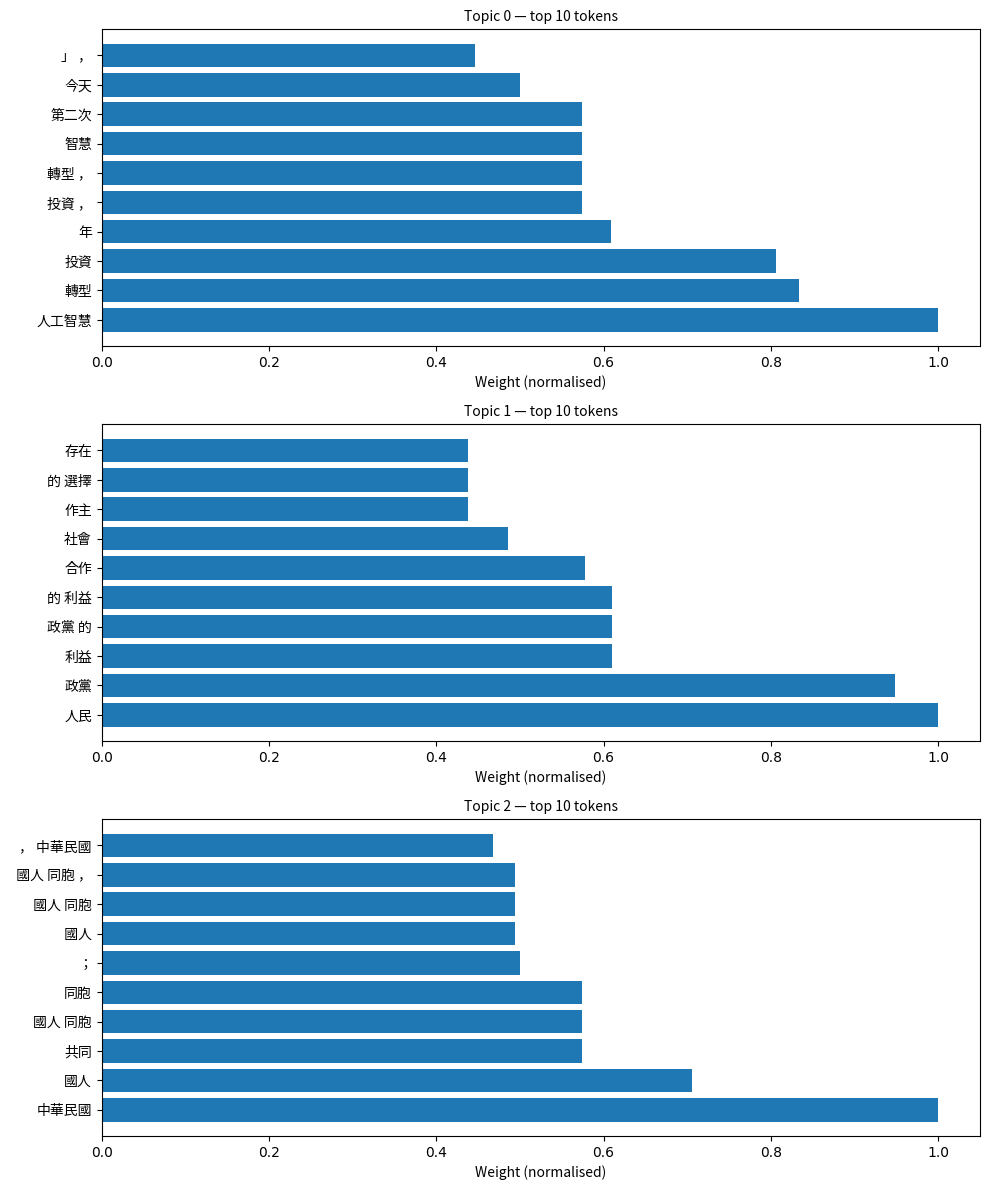

In [ ]:
def plot_topics_single_image(final_topic_model, topic_ids=None, k=3, top_n_words=10,
                             normalise=True, figsize=(10, 12), savepath=None):

    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    font_prop = FontProperties(
        fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
    )

    if topic_ids is None:
        info = final_topic_model.get_topic_info()
        info = info[info["Topic"] != -1]
        topic_ids = info.sort_values("Count", ascending=False).head(k)["Topic"].tolist()

    n = len(topic_ids)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=figsize)
    if n == 1:
        axes = [axes]

    for ax, tid in zip(axes, topic_ids):
        pairs = final_topic_model.get_topic(tid)
        if not pairs:
            ax.set_title(f"Topic {tid} (empty)")
            ax.axis("off")
            continue

        pairs = pairs[:top_n_words]
        words, weights = zip(*pairs)

        if normalise:
            mx = max(weights)
            weights = [w / mx if mx != 0 else 0 for w in weights]

        words = list(words)[::-1]
        weights = list(weights)[::-1]

        y_pos = range(len(words))
        ax.barh(y_pos, weights)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(words, fontproperties=font_prop)
        ax.invert_yaxis()


        ax.set_title(f"Topic {tid} — top {top_n_words} tokens", fontproperties=font_prop)
        ax.set_xlabel(
            "Weight" + (" (normalised)" if normalise else ""),
            fontproperties=font_prop
        )

    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()
    return topic_ids
top3 = plot_topics_single_image(
    final_topic_model_v2,
    k=3,
    top_n_words=10,
    normalise=True,
    figsize=(10, 12),
    savepath="top3_topics.png"
)


# **9. Topic Diagnostic after Tuning**

### **Topic Coherence**

In [ ]:
final_top_words_dict_v2 = {}

for topic_id, words_scores in final_topic_model_v2.get_topics().items():
    if topic_id == -1:
        continue
    top_words_dict_v2[topic_id] = [w for w, _ in words_scores]

In [ ]:
final_vectorizer_v2 = final_topic_model_v2.vectorizer_model

final_texts_cleaned_v2 = [
    final_vectorizer_v2.build_tokenizer()(doc)
    for doc in documents
]

from gensim.corpora import Dictionary

final_dictionary_v2 = Dictionary(final_texts_cleaned_v2)
final_dictionary_v2.filter_extremes(no_below=1, no_above=0.9)

final_dictionary_vocab_v2 = set(final_dictionary_v2.token2id.keys())

final_topics_for_gensim_v2 = []
final_topic_ids_for_gensim_v2 = []

for topic_id, words_scores in final_topic_model_v2.get_topics().items():
    if topic_id == -1:
        continue

    words_v2 = [w for w, _ in words_scores][:10]
    words_v2 = [w for w in words_v2 if w in final_dictionary_vocab_v2]

    if len(words_v2) < 2:
        continue

    final_topic_ids_for_gensim_v2.append(topic_id)
    final_topics_for_gensim_v2.append(words_v2)

In [ ]:
final_topics_for_gensim_v2 = []
final_topic_ids_for_gensim_v2 = []

for topic_id, words_scores in final_topic_model_v2.get_topics().items():
    if topic_id == -1:
        continue

    words_v2 = [w for w, _ in words_scores][:10]
    words_v2 = [w for w in words_v2 if w in final_dictionary_vocab_v2]

    if len(words_v2) < 2:
        continue

    final_topic_ids_for_gensim_v2.append(topic_id)
    final_topics_for_gensim_v2.append(words_v2)

from gensim.models import CoherenceModel

final_cm_umass_v2 = CoherenceModel(
    topics=final_topics_for_gensim_v2,
    texts=final_texts_cleaned_v2,
    dictionary=final_dictionary_v2,
    coherence="u_mass"
)

final_cm_uci_v2 = CoherenceModel(
    topics=final_topics_for_gensim_v2,
    texts=final_texts_cleaned_v2,
    dictionary=final_dictionary_v2,
    coherence="c_uci"
)

final_cm_npmi_v2 = CoherenceModel(
    topics=final_topics_for_gensim_v2,
    texts=final_texts_cleaned_v2,
    dictionary=final_dictionary_v2,
    coherence="c_npmi"
)
import pandas as pd

final_coherence_df_v2 = (
    pd.DataFrame({
        "topic_id": final_topic_ids_for_gensim_v2,
        "umass": final_cm_umass_v2.get_coherence_per_topic(),
        "uci": final_cm_uci_v2.get_coherence_per_topic(),
        "npmi": final_cm_npmi_v2.get_coherence_per_topic(),
    })
    .set_index("topic_id")
    .sort_index()
)

print(final_coherence_df_v2)
avg_umass_v2 = final_coherence_df_v2["umass"].mean()
avg_uci_v2 = final_coherence_df_v2["uci"].mean()
avg_npmi_v2 = final_coherence_df_v2["npmi"].mean()

print(f"[v2] Average UMass coherence: {avg_umass_v2:.4f}")
print(f"[v2] Average UCI coherence: {avg_uci_v2:.4f}")
print(f"[v2] Average NPMI coherence: {avg_npmi_v2:.4f}")

              umass        uci      npmi
topic_id                                
0        -14.321154 -13.948167 -0.414657
1         -9.168196 -12.091133 -0.355428
2         -4.032068 -11.435408 -0.326072
3        -12.246073 -10.784473 -0.304355
4        -17.743128 -17.433563 -0.625247
5         -1.344660  -6.896989 -0.108873
6         -8.948364 -11.768644 -0.408601
7         -7.100327  -7.173136 -0.084827
8        -15.873920 -10.264601 -0.148641
[v2] Average UMass coherence: -10.0864
[v2] Average UCI coherence: -11.3107
[v2] Average NPMI coherence: -0.3085


### **Topic Similarity**

In [ ]:
final_topics_dict_v2 = {
    tid: words
    for tid, words in final_topic_model_v2.get_topics().items()
    if tid != -1 and len(words) > 0
}
final_vocab_v2 = sorted({
    w for words in final_topics_dict_v2.values() for w, _ in words
})
final_vocab_index_v2 = {w: i for i, w in enumerate(final_vocab_v2)}
final_topic_vectors_v2 = {}

for tid, words in final_topics_dict_v2.items():
    vec = np.zeros(len(final_vocab_v2))
    for w, weight in words:
        vec[final_vocab_index_v2[w]] = weight
    if vec.sum() > 0:
        final_topic_vectors_v2[tid] = vec / vec.sum()
final_similarity_results_v2 = []

for i, j in combinations(final_topic_vectors_v2.keys(), 2):
    p, q = final_topic_vectors_v2[i], final_topic_vectors_v2[j]
    final_similarity_results_v2.append({
        "topic_1": i,
        "topic_2": j,
        "hellinger": hellinger(p, q),
        "kl": kl_divergence(p, q),
        "js": js_divergence(p, q),
        "cosine": 1 - cosine(p, q)
    })
final_similarity_df_v2 = pd.DataFrame(final_similarity_results_v2)

print("[v2] Hellinger:", round(final_similarity_df_v2.hellinger.mean(), 4))
print("[v2] KL:", round(final_similarity_df_v2.kl.mean(), 4))
print("[v2] JS:", round(final_similarity_df_v2.js.mean(), 4))
print("[v2] Cosine:", round(final_similarity_df_v2.cosine.mean(), 4))

[v2] Hellinger: 0.9908
[v2] KL: 24.8945
[v2] JS: 0.6808
[v2] Cosine: 0.0164


### **Topic Diversity**

In [ ]:
def topic_diversity_v2(final_topic_model_v2, top_n=10):

    topics_v2 = []

    for topic_id in final_topic_model_v2.get_topics().keys():
        if topic_id == -1:
            continue

        topic_words = final_topic_model_v2.get_topic(topic_id)
        if topic_words is None:
            continue

        words = [w for w, _ in topic_words[:top_n]]
        if len(words) == 0:
            continue

        topics_v2.append(words)

    if not topics_v2:
        return np.nan

    all_words = sum(topics_v2, [])
    return len(set(all_words)) / len(all_words)

diversity_v2 = topic_diversity_v2(final_topic_model_v2, top_n=10)
print(f"[v2] Topic diversity (top-10): {diversity_v2:.4f}")

[v2] Topic diversity (top-10): 0.9333


### **Interpretation of the New Results and Degradation After Tuning**

The tuned model still exhibits high topic diversity and strong inter-topic separation, as indicated by consistently large divergence scores and low cosine similarity. This suggests that topics remain well separated in the embedding space and that clustering boundaries are preserved.

However, coherence metrics decline after tuning, indicating weaker internal word co-occurrence within topics. This degradation likely arises because parameter tuning favored configurations that maximize global separation and cluster distinctiveness, which can come at the expense of lexical cohesion—especially in short, paragraph-level Chinese documents.

Overall, the tuning process appears to shift the balance toward topic distinctiveness rather than internal interpretability, which explains why separation metrics remain strong.


## **Conclusion**


This study applies a Chinese-aware topic modeling pipeline combining sentence-level embeddings, paragraph-based document segmentation, and Jieba tokenization to analyze structured political discourse. The results show that the corpus is dominated by themes related to governance, national identity, democracy, policy direction, and future-oriented development, including technology, economic transformation, and regional stability.

Quantitative evaluation indicates consistently high topic diversity and strong inter-topic separation, suggesting that the embedding and clustering components effectively distinguish semantic themes. Parameter tuning further sharpens topic separation but introduces a trade-off, as improved distinctiveness comes at the cost of reduced internal lexical coherence. This effect is amplified by short document lengths, Chinese tokenization characteristics, and rhetorical repetition within the source texts.

Overall, the final model produces thematically meaningful and well-separated topics that align with the underlying structure of the corpus, while highlighting inherent limitations of coherence-based evaluation metrics for short, Chinese-language documents.
